In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# AUC

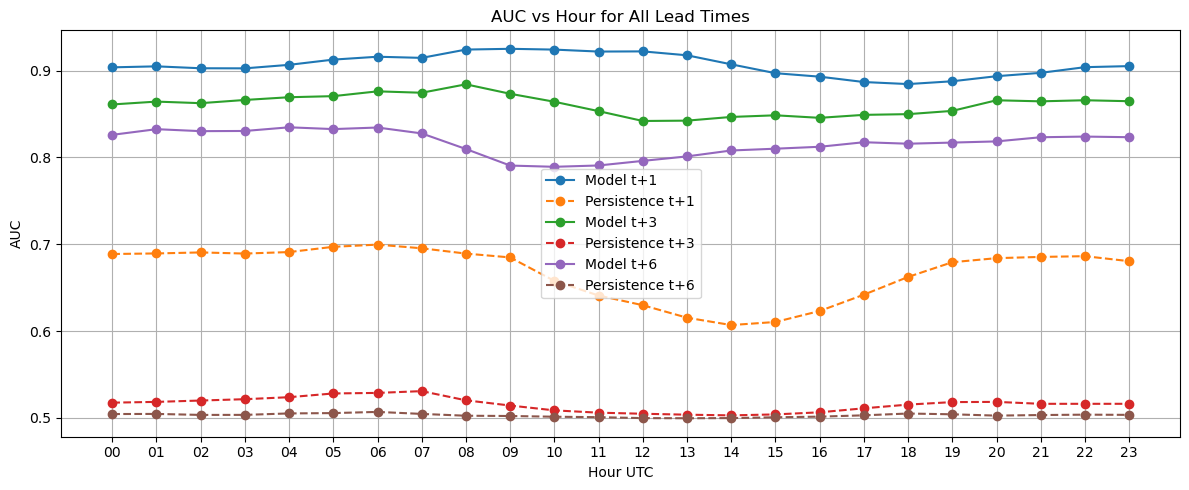

In [24]:
hours = [f"{h:02d}" for h in range(24)]
lead_times = ["1", "3", "6"]   # change if needed

auc_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/auc"

auc_model = {L: [] for L in lead_times}
auc_pers  = {L: [] for L in lead_times}

for L in lead_times:
    for h in hours:
        m_path = os.path.join(auc_dir, f"auc_model_hour_{h}_t{L}.npy")
        p_path = os.path.join(auc_dir, f"auc_persistence_hour_{h}_t{L}.npy")

        if os.path.exists(m_path):
            auc_model[L].append(float(np.load(m_path)))
            auc_pers[L].append(float(np.load(p_path)))
        else:
            auc_model[L].append(np.nan)
            auc_pers[L].append(np.nan)

plt.figure(figsize=(12,5))

for L in lead_times:
    plt.plot(hours, auc_model[L], marker="o", label=f"Model t+{L}")
    plt.plot(hours, auc_pers[L], marker="o", linestyle="--", label=f"Persistence t+{L}")

plt.xlabel("Hour UTC")
plt.ylabel("AUC")
plt.title("AUC vs Hour for All Lead Times")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
bins = {
    "00-02": ["00", "01", "02"],
    "03-05": ["03", "04", "05"],
    "06-08": ["06", "07", "08"],
    "09-11": ["09", "10", "11"],
    "12-14": ["12", "13", "14"],
    "15-17": ["15", "16", "17"],
    "18-20": ["18", "19", "20"],
    "21-23": ["21", "22", "23"],
}

bin_labels = list(bins.keys())


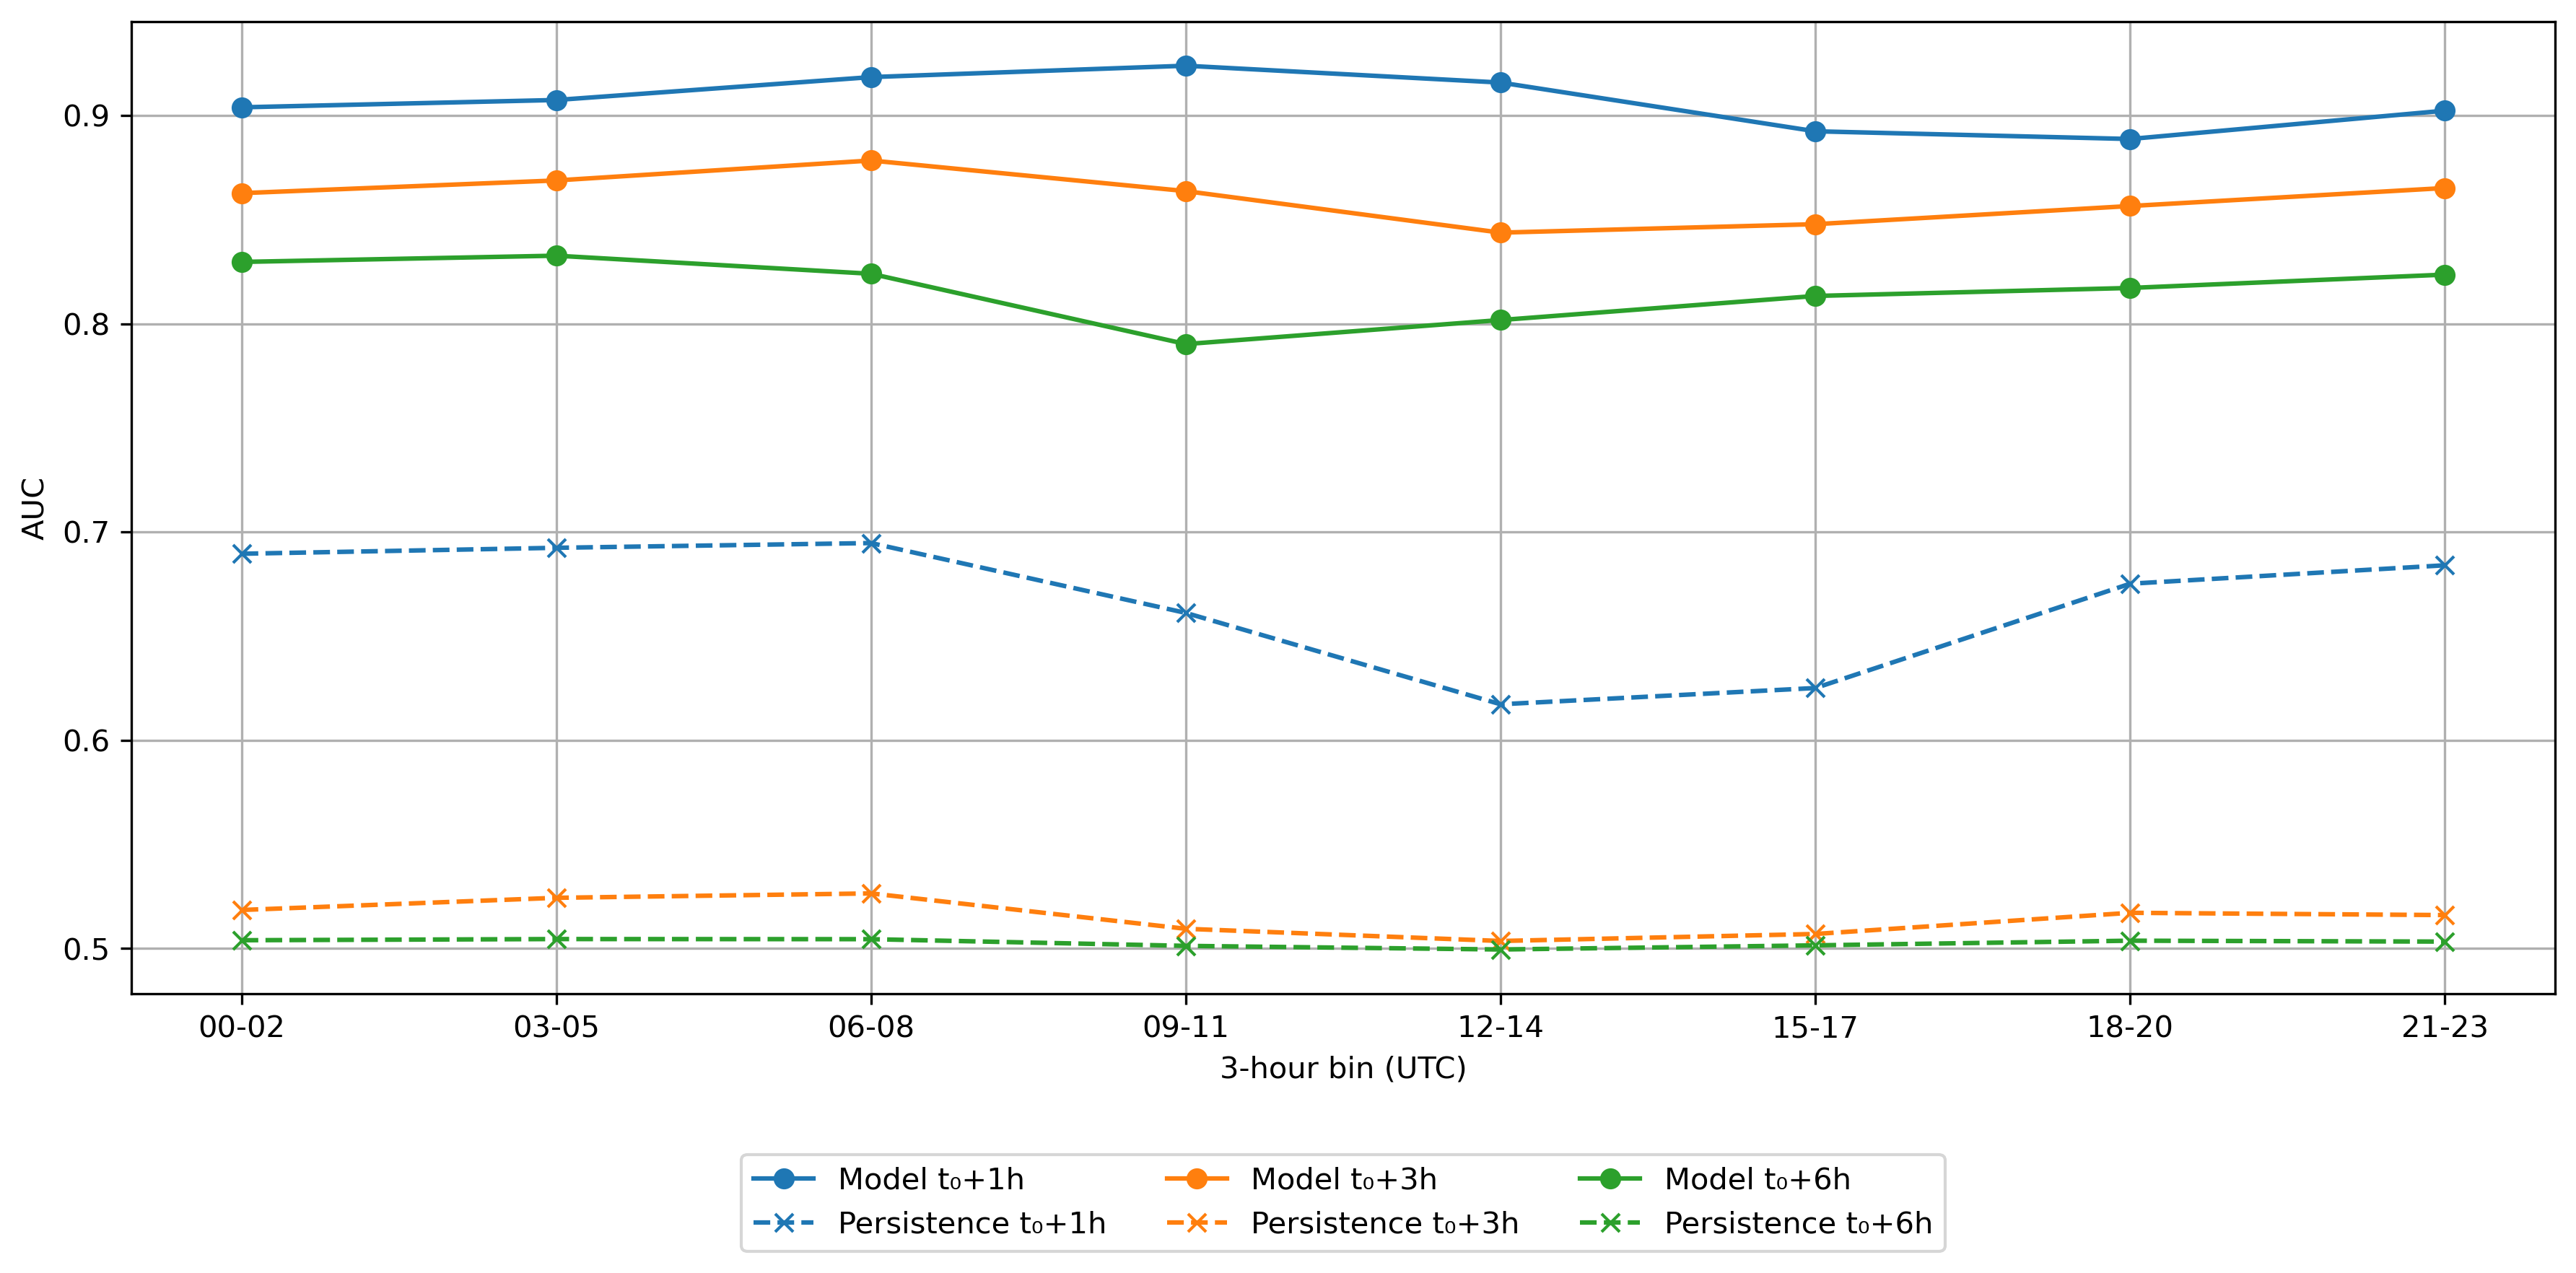

In [26]:
auc_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/auc"
lead_times = ["1", "3", "6"]

bins = {
    "00-02": ["00", "01", "02"],
    "03-05": ["03", "04", "05"],
    "06-08": ["06", "07", "08"],
    "09-11": ["09", "10", "11"],
    "12-14": ["12", "13", "14"],
    "15-17": ["15", "16", "17"],
    "18-20": ["18", "19", "20"],
    "21-23": ["21", "22", "23"],
}

bin_labels = list(bins.keys())
model_marker = "o"
pers_marker = "x"

def load_auc(hour, lead):
    m_path = os.path.join(auc_dir, f"auc_model_hour_{hour}_t{lead}.npy")
    p_path = os.path.join(auc_dir, f"auc_persistence_hour_{hour}_t{lead}.npy")
    if os.path.exists(m_path) and os.path.exists(p_path):
        return float(np.load(m_path)), float(np.load(p_path))
    return np.nan, np.nan

# -----------------------
# Compute binned AUC
# -----------------------
auc_model_binned = {L: [] for L in lead_times}
auc_pers_binned = {L: [] for L in lead_times}

for L in lead_times:
    for label in bin_labels:
        hours = bins[label]
        vals_m = []
        vals_p = []
        for h in hours:
            am, ap = load_auc(h, L)
            vals_m.append(am)
            vals_p.append(ap)

        auc_model_binned[L].append(np.nanmean(vals_m))
        auc_pers_binned[L].append(np.nanmean(vals_p))

# -----------------------
# Plot (with UTF-8 t₀)
# -----------------------
plt.figure(figsize=(12,6), dpi=300)

colours = {
    "1": "C0",
    "3": "C1",
    "6": "C2",
}

for L in lead_times:
    c = colours[L]
    label_suffix = f"t₀+{L}h"   # UTF-8 subscript zero

    # model
    plt.plot(
        bin_labels,
        auc_model_binned[L],
        marker=model_marker,
        linestyle="-",
        color=c,
        label=f"Model {label_suffix}",
    )

    # persistence
    plt.plot(
        bin_labels,
        auc_pers_binned[L],
        marker=pers_marker,
        linestyle="--",
        color=c,
        label=f"Persistence {label_suffix}",
    )

plt.xlabel("3-hour bin (UTC)")
plt.ylabel("AUC")
plt.grid(True)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3
)

plt.tight_layout()
plt.show()


# BSS

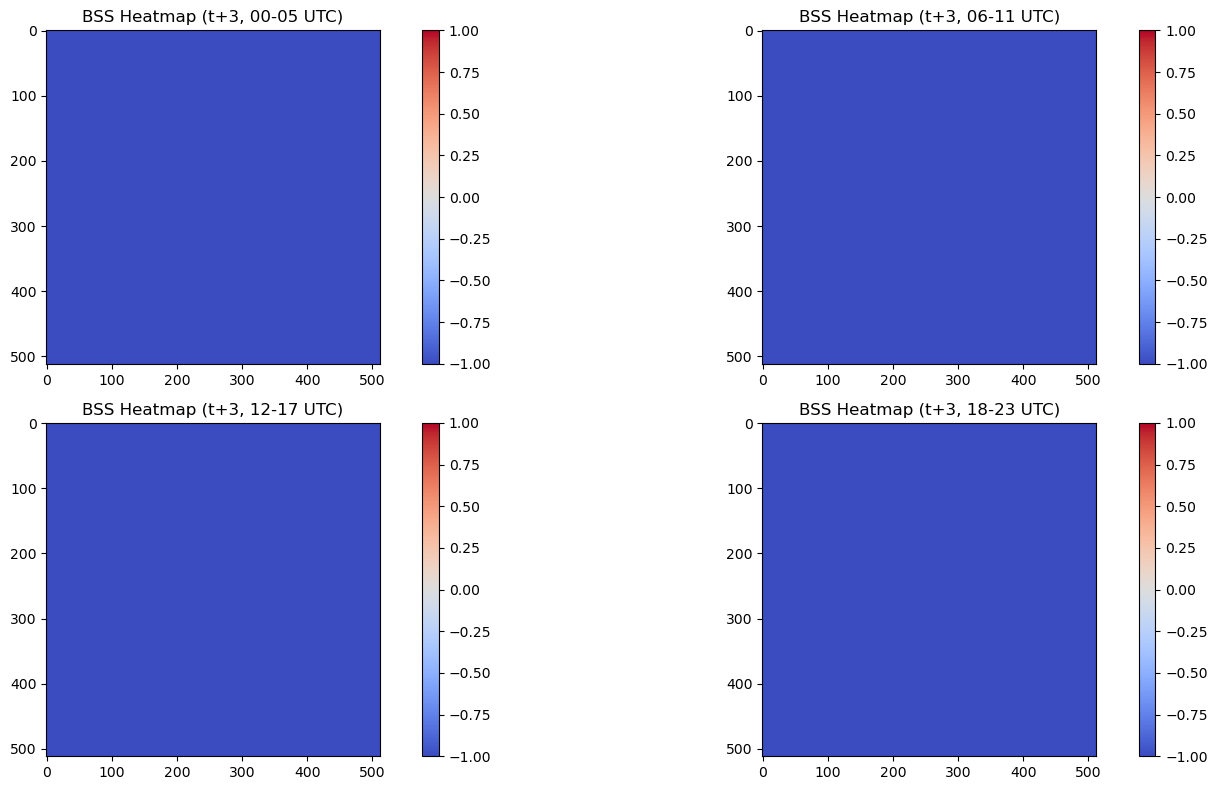

In [27]:
bss_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/bss"
lead_time = "3"  # change if needed

bins = {
    "00-05": ["00", "01", "02", "03", "04", "05"],
    "06-11": ["06", "07", "08", "09", "10", "11"],
    "12-17": ["12", "13", "14", "15", "16", "17"],
    "18-23": ["18", "19", "20", "21", "22", "23"],
}

def load_bss(hour, lead):
    path = os.path.join(bss_dir, f"bss_model_hour_{hour}_t{lead}.npy")
    if os.path.exists(path):
        return np.load(path)
    return None

bss_bin_maps = {}

for label, hours in bins.items():
    maps = []
    for h in hours:
        arr = load_bss(h, lead_time)
        if arr is not None:
            maps.append(arr)
    if len(maps) > 0:
        bss_bin_maps[label] = np.nanmean(np.stack(maps, axis=0), axis=0)
    else:
        bss_bin_maps[label] = None

plt.figure(figsize=(16,8))

i = 1
for label in bins.keys():
    bss_map = bss_bin_maps[label]
    if bss_map is None:
        continue
    # bss_map = np.clip(bss_map, -1, 1)
    plt.subplot(2,2,i)
    plt.imshow(bss_map, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"BSS Heatmap (t+{lead_time}, {label} UTC)")
    plt.colorbar()
    i += 1

plt.tight_layout()
plt.show()


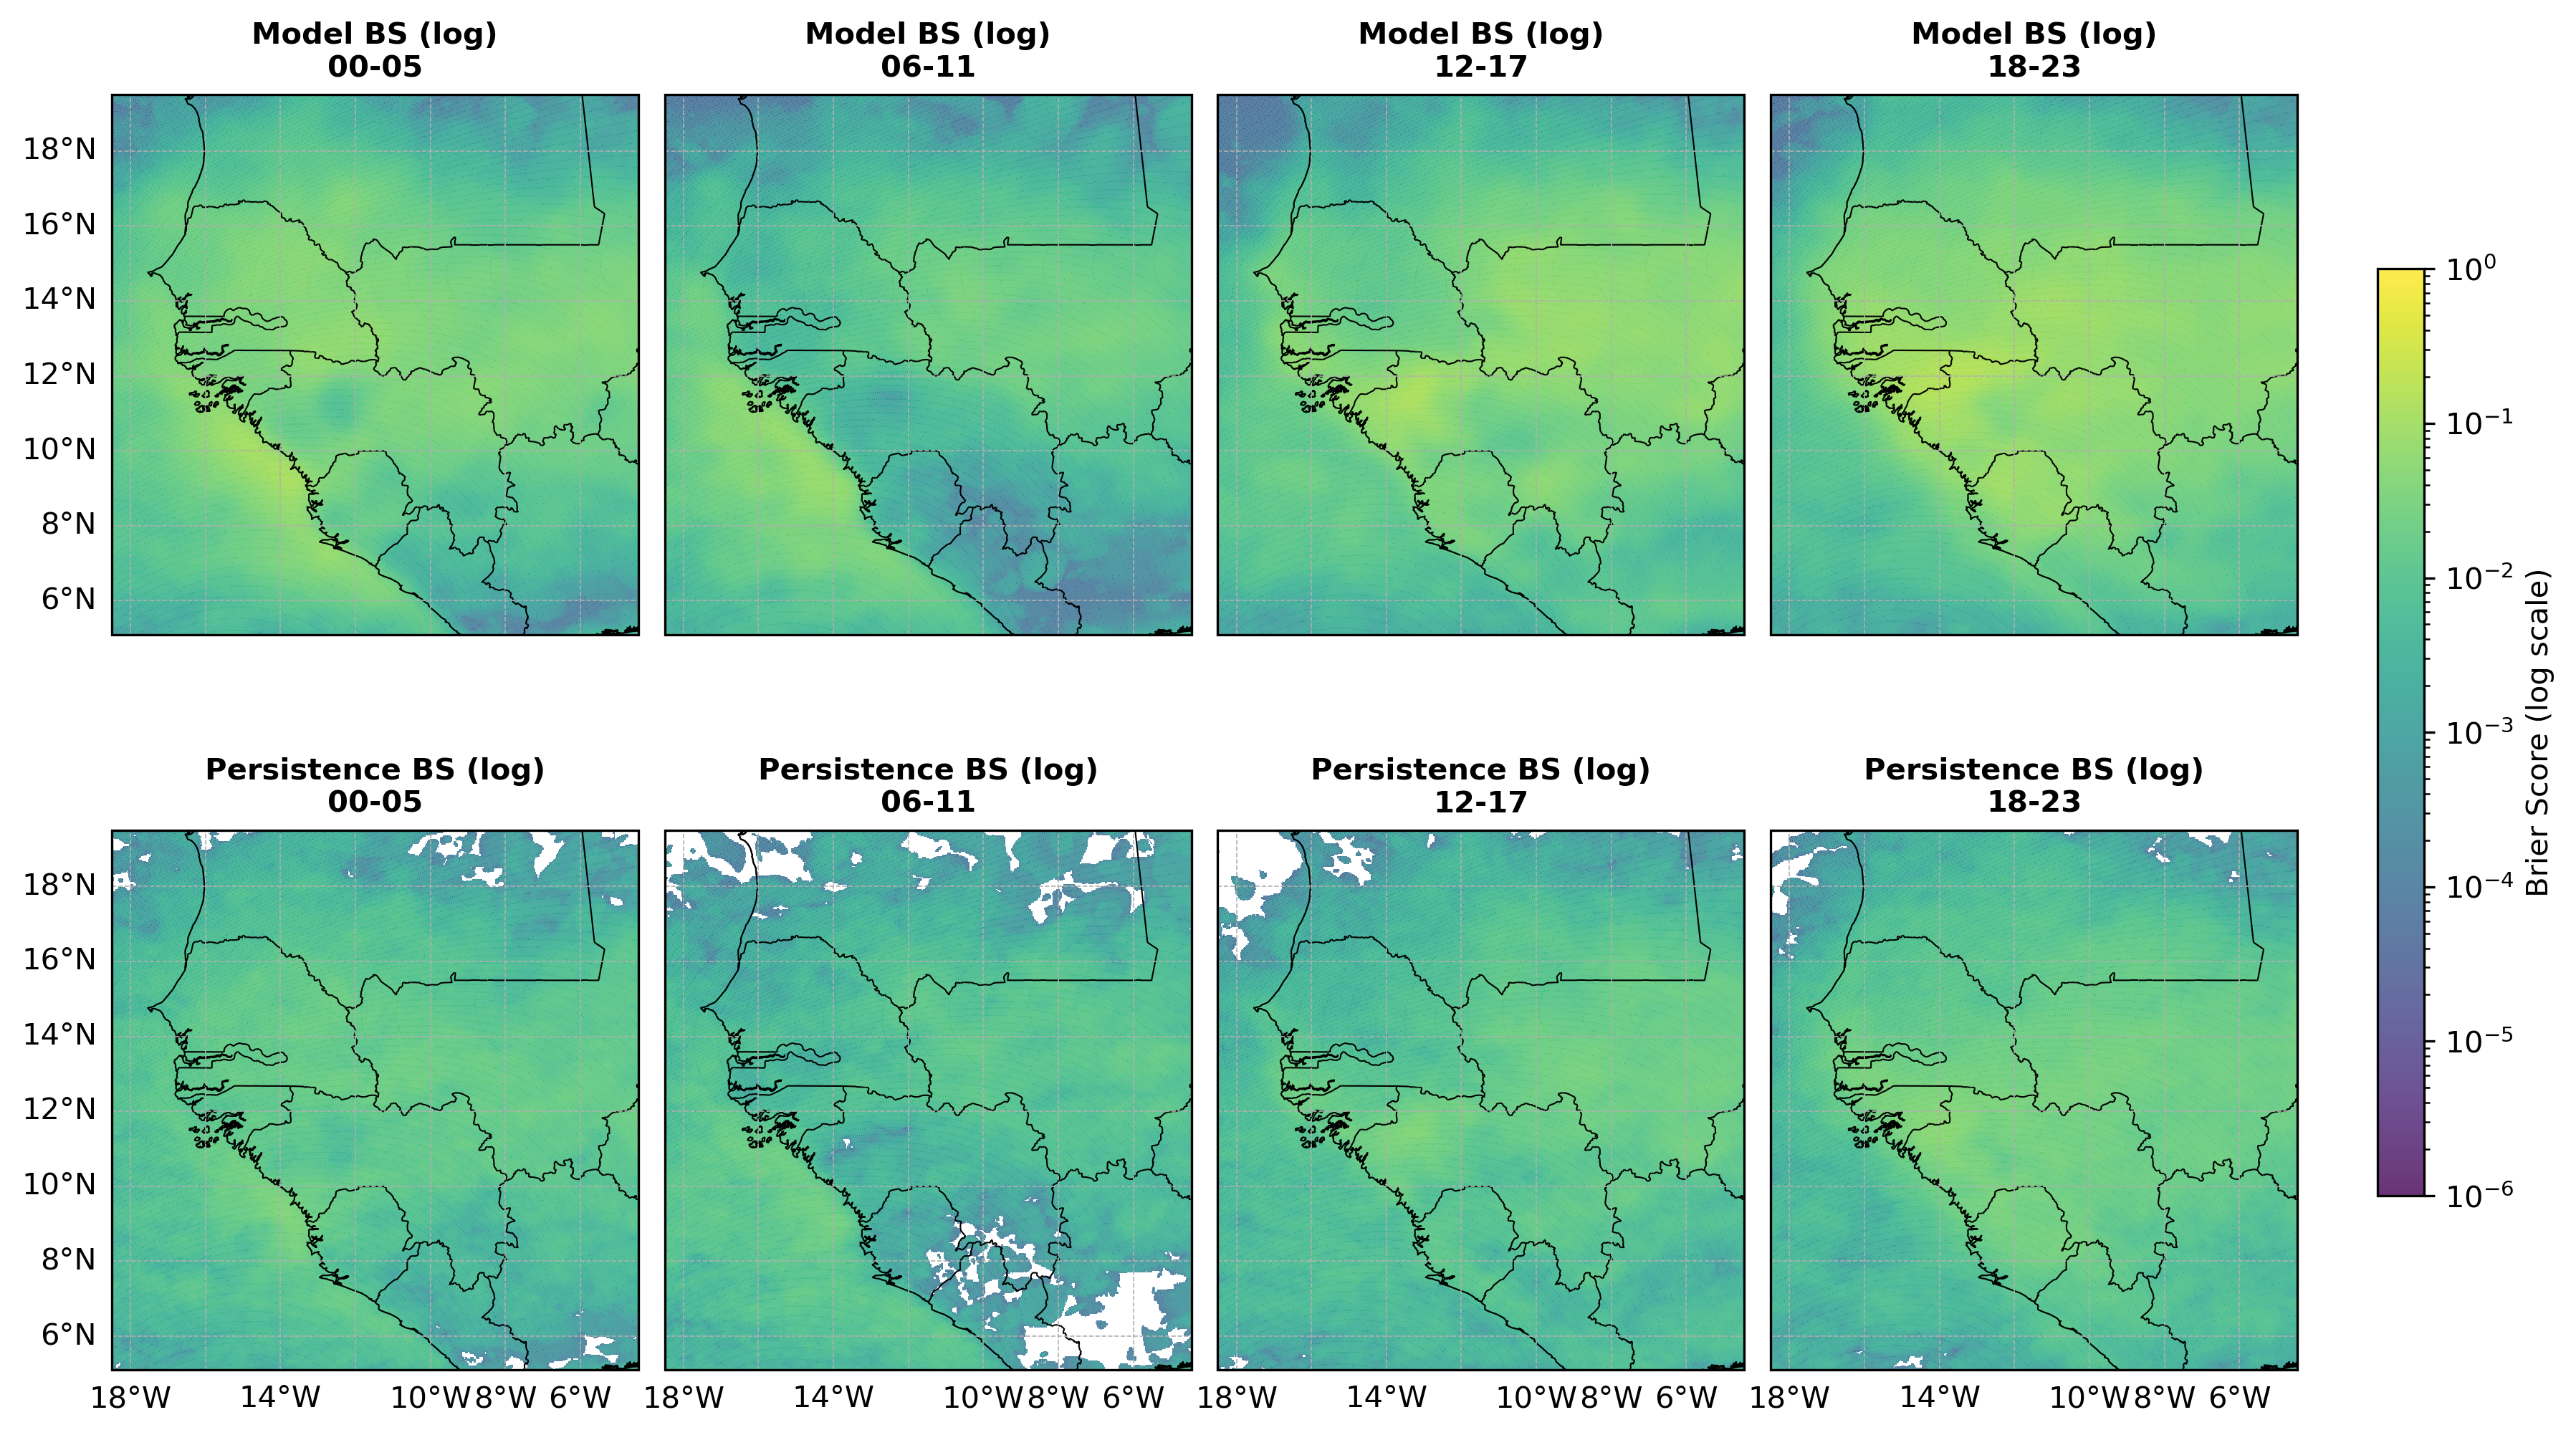

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

bs_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/bs"
lead_time = "1"

bins = {
    "00-05": ["00", "01", "02", "03", "04", "05"],
    "06-11": ["06", "07", "08", "09", "10", "11"],
    "12-17": ["12", "13", "14", "15", "16", "17"],
    "18-23": ["18", "19", "20", "21", "22", "23"],
}

def load_bs_model(hour, lead):
    path = os.path.join(bs_dir, f"bs_model_hour_{hour}_t{lead}.npy")
    if os.path.exists(path):
        return np.load(path)
    return None

def load_bs_persist(hour, lead):
    path = os.path.join(bs_dir, f"bs_persist_hour_{hour}_t{lead}.npy")
    if os.path.exists(path):
        return np.load(path)
    return None

# compute means per bin
model_maps = {}
pers_maps = {}

for label, hours in bins.items():
    m_arrs, p_arrs = [], []
    for h in hours:
        m = load_bs_model(h, lead_time)
        p = load_bs_persist(h, lead_time)
        if m is not None:
            m_arrs.append(m)
        if p is not None:
            p_arrs.append(p)

    model_maps[label] = np.nanmean(np.stack(m_arrs), axis=0) if m_arrs else None
    pers_maps[label] = np.nanmean(np.stack(p_arrs), axis=0) if p_arrs else None

groups = [(label, model_maps[label], pers_maps[label])
          for label in bins.keys()
          if model_maps[label] is not None and pers_maps[label] is not None]

if not groups:
    raise RuntimeError("No valid BS maps found.")

lat_min, lat_max = 5.1, 19.5
lon_min, lon_max = -18.5, -4.45

n_groups = len(groups)
fig, axes = plt.subplots(
    2, n_groups,
    figsize=(4 * n_groups, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300
)

plt.subplots_adjust(hspace=0.25, wspace=0.05)

vmin, vmax = 1e-6, 1

shapename = "admin_0_countries"
countries_shp = shpreader.natural_earth(resolution="10m",
                                        category="cultural", name=shapename)
africa_geoms = [rec.geometry for rec in shpreader.Reader(countries_shp).records()]

x_ticks = np.arange(-20, 0, 2)
y_ticks = np.arange(4, 22, 2)

for i, (label, bs_m, bs_p) in enumerate(groups):
    for row, bs_map in enumerate([bs_m, bs_p]):
        ax = axes[row, i]
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        ax.add_feature(cfeature.LAND, facecolor="none", edgecolor="black", linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor="none")
        ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)

        im = ax.pcolormesh(
            lons, lats, bs_map,
            transform=ccrs.PlateCarree(),
            cmap="viridis",
            norm=colors.LogNorm(vmin=vmin, vmax=vmax),
            shading="auto",
            alpha=0.8
        )

        gl = ax.gridlines(draw_labels=True, alpha=1, linestyle="--", linewidth=0.4)
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = (row == 1)
        gl.left_labels = (i == 0)
        gl.xlocator = mticker.FixedLocator(x_ticks)
        gl.ylocator = mticker.FixedLocator(y_ticks)

        if row == 0:
            ax.set_title(f"Model BS (log)\n{label}", fontsize=10, fontweight="bold")
        else:
            ax.set_title(f"Persistence BS (log)\n{label}", fontsize=10, fontweight="bold")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                    shrink=0.7, pad=0.03,
                    label="Brier Score (log scale)")

plt.show()


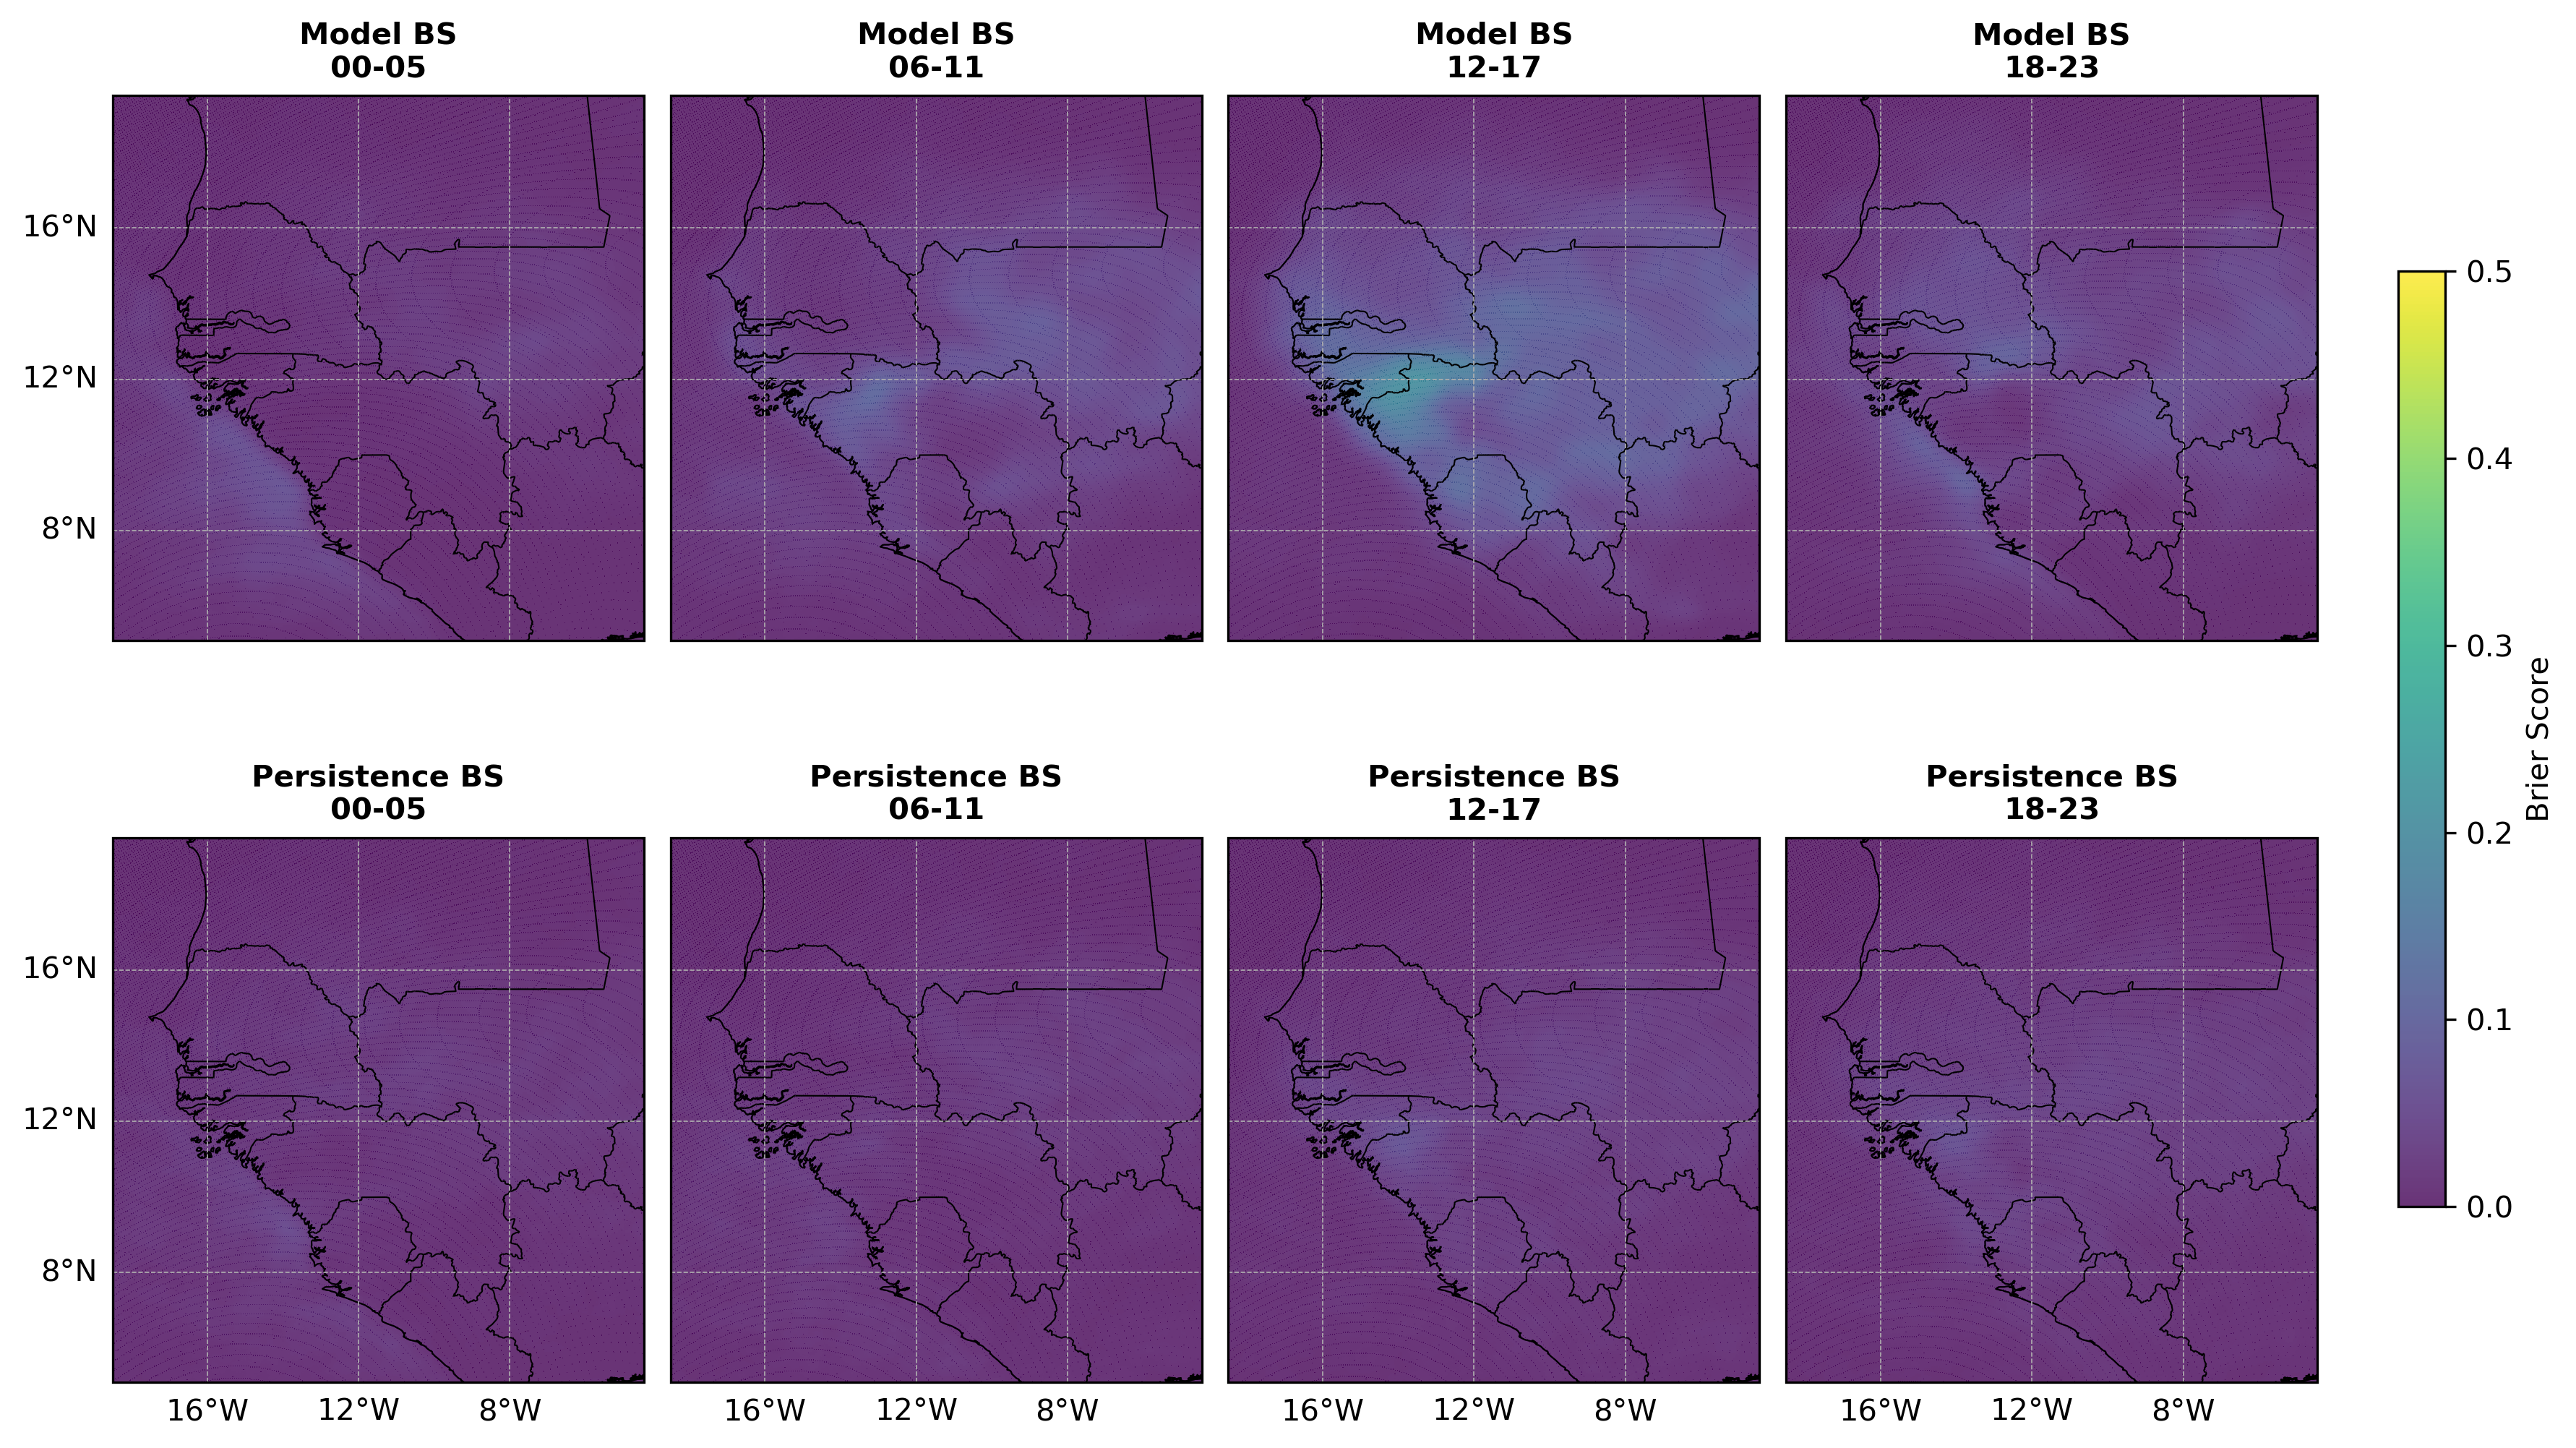

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

bs_dir = "/home/users/mendrika/Object-Based-LSTMConv/outputs/evaluation/bs"
lead_time = "6"

bins = {
    "00-05": ["00", "01", "02", "03", "04", "05"],
    "06-11": ["06", "07", "08", "09", "10", "11"],
    "12-17": ["12", "13", "14", "15", "16", "17"],
    "18-23": ["18", "19", "20", "21", "22", "23"],
}

def load_bs_model(hour, lead):
    path = os.path.join(bs_dir, f"bs_model_hour_{hour}_t{lead}.npy")
    if os.path.exists(path):
        return np.load(path)
    return None

def load_bs_persist(hour, lead):
    path = os.path.join(bs_dir, f"bs_persist_hour_{hour}_t{lead}.npy")
    if os.path.exists(path):
        return np.load(path)
    return None

model_maps = {}
pers_maps = {}

for label, hours in bins.items():
    m_arrs, p_arrs = [], []
    for h in hours:
        m = load_bs_model(h, lead_time)
        p = load_bs_persist(h, lead_time)
        if m is not None:
            m_arrs.append(m)
        if p is not None:
            p_arrs.append(p)

    model_maps[label] = np.nanmean(np.stack(m_arrs), axis=0) if m_arrs else None
    pers_maps[label] = np.nanmean(np.stack(p_arrs), axis=0) if p_arrs else None

groups = [(label, model_maps[label], pers_maps[label])
          for label in bins.keys()
          if model_maps[label] is not None and pers_maps[label] is not None]

if not groups:
    raise RuntimeError("No valid BS maps found.")


lat_min, lat_max = 5.1, 19.5
lon_min, lon_max = -18.5, -4.45

n_groups = len(groups)
fig, axes = plt.subplots(
    2, n_groups,
    figsize=(4 * n_groups, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300
)

plt.subplots_adjust(hspace=0.25, wspace=0.05)

vmin, vmax = 0, 0.5

shapename = "admin_0_countries"
countries_shp = shpreader.natural_earth(resolution="10m",
                                        category="cultural", name=shapename)
africa_geoms = [rec.geometry for rec in shpreader.Reader(countries_shp).records()]

x_ticks = np.arange(-20, 0, 4)
y_ticks = np.arange(4, 22, 4)

for i, (label, bs_m, bs_p) in enumerate(groups):
    for row, bs_map in enumerate([bs_m, bs_p]):
        ax = axes[row, i]
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        ax.add_feature(cfeature.LAND, facecolor="none", edgecolor="black", linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor="none")
        ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)

        im = ax.pcolormesh(
            lons, lats, bs_map,
            transform=ccrs.PlateCarree(),
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            shading="auto",
            alpha=0.8
        )

        gl = ax.gridlines(draw_labels=True, alpha=1, linestyle="--", linewidth=0.4)
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = (row == 1)
        gl.left_labels = (i == 0)
        gl.xlocator = mticker.FixedLocator(x_ticks)
        gl.ylocator = mticker.FixedLocator(y_ticks)

        if row == 0:
            ax.set_title(f"Model BS\n{label}", fontsize=10, fontweight="bold")
        else:
            ax.set_title(f"Persistence BS\n{label}", fontsize=10, fontweight="bold")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                    shrink=0.7, pad=0.03,
                    label="Brier Score")

plt.show()
